# SVCCA - Singular Vector Canonical Correlation Analysis

Paper: https://arxiv.org/abs/1706.05806

Code taken from: https://github.com/google/svcca

In [1]:
import numpy as np
from cca_core import get_cca_similarity

# Toy Example of CCA in action

# assume X_fake has 100 neurons and we have their activations on 1000 datapoints
A_fake = np.random.randn(100, 2000)
# Y_fake has 50 neurons with activations on the same 1000 datapoints
# Note X and Y do *not* have to have the same number of neurons
B_fake = np.random.randn(50, 2000)

# computing CCA simliarty between X_fake, Y_fake
# We expect similarity should be very low, because the fake activations are not correlated
results = get_cca_similarity(A_fake, B_fake, verbose=False)
results.keys()

dict_keys(['coef_x', 'invsqrt_xx', 'full_coef_x', 'full_invsqrt_xx', 'coef_y', 'invsqrt_yy', 'full_coef_y', 'full_invsqrt_yy', 'neuron_means1', 'neuron_means2', 'cca_coef1', 'cca_coef2', 'x_idxs', 'y_idxs', 'mean', 'sum'])

In [2]:
results["mean"]

(0.21413328053544411, 0.21413328053544411)

In [3]:
np.mean(results["cca_coef1"])

0.20855189831600204

In [4]:
from cross_lingual_subnets.cka import cka

In [5]:
import numpy as np

# Compare the representations of 2 networks
# One has 8 layers and 300 dimensional encodings
# The other has 10 layers and 300 dimensional encodings
# Both evaluated on the same 1k examples
repr1 = np.random.randn(8, 300, 1000)
repr2 = np.random.randn(10, 300, 1000)

In [6]:
cka_results = dict()
for i, layer_reprs1 in enumerate(repr1):
    res = []
    for layer_reprs2 in repr2:
        res.append(cka(layer_reprs1, layer_reprs2))
    cka_results[i] = res

In [7]:
import pandas as pd

df = pd.DataFrame(cka_results)
df = df.sort_index(ascending=False)

[Text(0.5, 23.52222222222222, 'Layer'), Text(50.722222222222214, 0.5, 'Layer')]

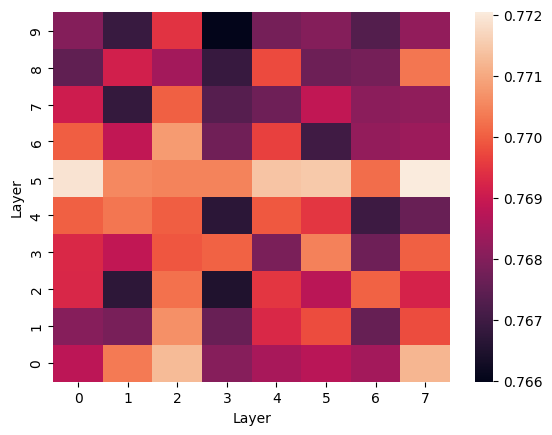

In [8]:
import seaborn as sns

ax = sns.heatmap(df)
ax.set(xlabel="Layer", ylabel="Layer")

## Full vs pruned model representation similarity

TODO:
Similarity of full vs pruned model one language:
- take finetuned model representation of english, pruned model representation of english
- over layers, compute SVCCA and CKA scores
- do this for a english and other language pairs

## Language representation similarity

TODO:
Similarity of full vs pruned model cross languages:
- take finetuned model representation of english, pruned model representation of spanish
- over layers, compute SVCCA and CKA scores
- do this for a english and other language pairs